In [62]:
# hide
import sys
sys.path.append("..")

In [63]:
# default_exp solar_flux_time_series_forecasting

# PyTorch Implementation of N-BEATS for Solar Flux Data

* paper: https://arxiv.org/abs/1905.10437
* https://paperswithcode.com/paper/n-beats-neural-basis-expansion-analysis-for
    * pytorch implementation: https://github.com/philipperemy/n-beats/blob/master/examples/NBeats.ipynb
* model versioning with pytorch: https://github.com/wandb/examples/blob/master/pytorch-intro/intro.ipynb

@inproceedings{
  Oreshkin2020:N-BEATS,
  title={{N-BEATS}: Neural basis expansion analysis for interpretable time series forecasting},
  author={Boris N. Oreshkin and Dmitri Carpov and Nicolas Chapados and Yoshua Bengio},
  booktitle={International Conference on Learning Representations},
  year={2020}
}

Notes:
* wandb used for saving preds, targs, times, model (and for saving ensemble members): wandb.save (save best model, preds, targs)
* be careful of using wandb.watch(all) -- may be too large to retrieve sweep later
* RAdam and Ranger with adaptive learning rate (warm up during training, lower learning rate for first layers) implemented
* weight decay not advantageous during training
* gendate (== pred_date) is taken as first day of horizon (so gendate == forecast day 1) (as for CLS, BGS)
* persistence as yesterday's truth (not today's, gendate)

## Imports

In [64]:
!python3 --version

Python 3.6.9


In [65]:
!pip3 install torch-optimizer

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [66]:
# export
import os
import sys
import pprint
import time
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pathlib import Path
import torch
# original pytorch optimisers
from torch import optim 
# add on package with extra optimisers e.g. RAdam
import torch_optimizer as optim2
from torch.nn import functional as F

In [67]:
torch.cuda.device_count(), torch.cuda.is_available(), torch.cuda.current_device()

(2, True, 1)

In [68]:
# export
# WandB – Import the wandb library
import wandb

In [69]:
# export
from lib.stats_utils import cStationary, cErrorMetrics
from lib.plot_utils import GridStrategy
from lib.read_data import cESA_SWE, cCLS_CNES
from lib.model import NBeatsNet

In [70]:
# WandB – Login to your wandb account so you can log all your metrics
#!wandb login <add your key here>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## User Config

In [71]:
# export
# cannot change values during sweep while also sweeping over (therefore need parameters such as assign_seed and lookback_hfactor)
user_config = {
        
    # data
    "data_src"            : "esa",              # use esa archive data to learn from ("esa" or "cls")
    "data_comp"           : ["esa", "cls"],     # external forecasts to compare to ("esa" and or "cls")
    "date_llim"           : "1949-12-31",       # lower date cut for data for training/testing
    "date_ulim"           : "2021-01-01",       # upper date cut for data for training/testing
    "get_daily_method"    : "20:00",            # (for esa archive data) "interp", "20:00", False
    "missing_data_method" : "interp_linear",    # (for esa archive data) "interp_linear", "pad", False
    
    # esa data
    "esa_archive_fname"  : "../data/archive/F10.7DailyObservedFluxDensity.txt",      # esa archived data to learn from
    "esa_forecast_fname" : "../data/forecast/F10.7_IndexForecast27day_BGS_2017.txt", # esa forecast data to compare to
    "esa_archive_key"    : "f10_7",                  # key for datadict of filenames
    "esa_forecast_key"   : "F107_NMH_esforc",        # key for datadict of filenames
    
    # cls-cnes data
    "cls_datadir"        : "../data/cls",            # directory where data is downloaded to
    "cls_key"            : "f10.7",                  # key for column header
    "cls_forecast_ldate" : "2016-12-31",             # lower date to download cls from for forecast files
    "cls_forecast_udate" : "2021-01-01",             # upper date to download cls to for forecast files
    "cls_adj"            : False,                    # adjusted data? or absolute
    
    # data pre processing + batching
    "horizon"             : 5,                  # define window size (forecast_length)
    "lookback"            : 15,                 # define window size (backcast_length)
    "lookback_hfactor"    : "3H",               # use if want to define lookback as a factor of horizon (e.g. "3H") (default False)
    "step"                : 1,                  # step of sliding window
    "incl_test"           : False,              # generate test set?
    "test_pct"            : 0.1,                # train:test split (also do this with a date instead of a percentage?)
    "valid_pct"           : 0.2,                # train:validation split
    "batch_size"          : "max",              # number of windows to be batched together for training (e.g. 16, 32, 64)
                                                # (higher means better convergence but more computational expense)
                                                # terrible results with bs 64, better with over 5000
                                                # give number or "max" to just use all data in single batch (as done in previous implementation)
    
    # nbeats model hyperparameters
    # (paper (generic): 1 block per stack, 30 stacks, bs=1024, width=512, no weight sharing)
    # (philippemery: 128 hidden units, 3 blocks per stack, theta_dims [7,8], no weight sharing)
    "model_type"             : "generic",    # nbeats ("generic" or "interpretable")
    "nb_stacks"              : 5,           # nbeats (only if "generic", number of stacks) (if "interpretable", 2 stacks: "trend", "seasonality")
    "share_weights_in_stack" : False,        # nbeats (default False) (would overfit less if true)
    "thetas_dims"            : [7, 8],       # nbeats (default [7, 8]) (dimensions must match number of stacks else will be duplicated) (if using trend block: max theta dimension == 4)
    "nb_blocks_per_stack"    : 1,            # nbeats (default 3) 
    "width"                  : 512,          # nbeats (default 128) (number of neurons, hidden_layer_units)
    
    # training parameters
    "assign_seed"         : False,                     # if False use "seed" else randomly assign (default True)
    "seed"                : 103115806466,              # set seed for weights initialisation (for reproducibility & to sweep over for ensemble) #4970606073122012649
    "optimiser"           : "RAdam",                   # "Adam", "SGD", "RAdam", "Ranger"
    "learning_rate"       : 0.001,                     # learning rate (default 0.001)
    "momentum"            : 0.5,                       # SGD momentum (default 0.5) (needed for SGD optimiser)
    "loss_func"           : "mse",                     # loss function for training "mse", "mae", "mape", "smape", "mase"
    "naive_season"        : 1,                         # seasonality for naive model for MASE (1 is sort of persistence)
    "metric"              : "mse",                     # (to be implemented)
    "epochs"              : 10,                        # total number of iterations of evaluating testing losses after model training # 30 epochs?
    "grad_steps"          : 100,                       # total number of training gradient steps per batch iteration per epoch
    "log_interval"        : 50,                        # num training steps to log validation losses
    "weight_decay"        : 0.,                        # weight decay specified in optimiser (default 0) (shouldn't need here)
    
    # saved files
    "CHECKPOINT_NAME"     : 'models/nbeats-training-checkpoint.th',  # should not use .pth extension for checkpointing
    "model_fname"         : "models/best.pth",                       # nbeats best model output file (default "models/best.pth")
    "preds_valid_fname"   : "models/preds_valid.pickle",             # interp pickle output file (default "models/interp.pickle") (useful for plotting after runs) (includes preds and targs)
    "preds_test_fname"    : "models/preds_test.pickle",              # interp pickle output file (default "models/interp.pickle") (useful for plotting after runs)
    "compdf_fname"        : "models/forecast_comp.pickle",           # pickle pandas dataframe of nbeats vs external forecasts
    
    # other
    "cuda"                : True,                # use GPU for training if available
    "use_wandb"           : False,               # "wandb_mode" : "run" or "dryrun" (run online or offline)
    "sweep"               : False,               # single run or part of larger sweep
    "verbose"             : True,                # printout during run
    "plot"                : True,                # plot during run
}

## Data Loader

In [72]:
# export
class AttrDict(dict):
    """
    access dictionary keys as attributes

    obj = AttrDict()
    obj.update(dict)
    """
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [73]:
# export
class cStore():
    """
    store attributes
    """
    pass

In [74]:
# export
class cSWEDataLoader():
    """
    dataloader class
    
    rolling window, norm, batch, train:valid:test split
    
    save data and times as attributes and have methods for denormalising etc.
    
    Attributes:
    df            = original data (as read from file or api)
    df_denorm     = preprocessed data (daily, interpolated missing etc.) before norming
    df_norm       = normalised df_denorm
    norm_constant = constant for normalising to df_norm
    train, valid, test
    """
    
    def __init__(self, config, verbose=False, plot=False):
        self.config  = config
        self.verbose = verbose
        self.plot    = plot
    
    def fread_data(self):
        """
        Read in data to use for training
        """
        # esa swe database
        if self.config.data_src == "esa":
            
            if self.verbose: 
                print("Training data source: ESA")
                
            self.dataobj = cESA_SWE(self.verbose)
            dfa_esa = self.dataobj.fget_data(filenames=self.config.esa_archive_fname)[self.config.esa_archive_key]
            dfa_esa.set_index('ds', inplace=True)

            self.df = dfa_esa

        # cls-cnes service
        elif self.config.data_src == "cls":
            
            if self.verbose: 
                print("Training data source: CLS")
                
            self.dataobj = cCLS_CNES(self.verbose)
            dfa_cls = self.dataobj.fget_archive_data(self.config.cls_datadir, \
                                                     self.config.date_llim, self.config.date_ulim, \
                                                     adj = self.config.cls_adj)
            dfa_cls = dfa_cls[['ds', self.config.cls_key]]
            dfa_cls = dfa_cls.set_index("ds")
            dfa_cls.columns = ["y"]
            
            self.df = dfa_cls
    
        # plot original data
        if self.plot:
            fig, ax = plt.subplots()
            ax.plot(self.df)
            plt.show()
    
    def fnormalise(self, df):
        """
        normalise based on max of training data
        """
        # normalisation based only on training data
        train_pct = 1
        if self.config.incl_test:
            train_pct = train_pct*(1 - self.config.test_pct)
        train_pct = train_pct*(1 - self.config.valid_pct)
        
        # use training subset of df for getting norm constant
        idx_lim = int(train_pct*len(df))

        self.norm_constant = np.max(df.y[:idx_lim])
        
        # normalise whole dataset
        return df/self.norm_constant
    
    def fdenormalise(self):
        """
        targs_denorm = np.asarray([y_test[i]*norm_constant for i in range(len(p))])
        preds_denorm = np.asarray([p[i]*norm_constant for i in range(len(p))])
        """
        pass
            
    def fpreprocess(self):
        """
        Interpolate and normalise data
        """
        # take subset of data
        df_lim = self.df[self.config.date_llim:self.config.date_ulim]
        
        # get daily values
        df_daily = self.dataobj.fget_daily(df_lim, self.config.get_daily_method)
        
        # account for missing data
        df_interp = self.dataobj.fmissing_data(df_daily, self.config.missing_data_method)

        # save unnormalised data
        self.df_denorm = df_interp
        
        # normalise data
        self.df_norm = self.fnormalise(self.df_denorm)

    def fget_windows(self, data, dates):
        """
        Batch into sliding windows

        data = numpy array of values
        (e.g. array([[0.60784314],
           [0.57894737],
           [0.66047472],)
           
        x,y = lookback, targets
        t = dates over forecast window (later should use first date of each time window as gendate)
        # first date after backcast length = 1st of forecast length (should check this lines up)
        """
        x, y, t = [], [], []
        for i in range(self.config.lookback, len(data) - self.config.horizon, self.config.step):
            x.append(data[i - self.config.lookback:i])
            y.append(data[i:i + self.config.horizon])
            t.append(dates[i:i + self.config.horizon]) #dates[i])

        x = np.array(x)[..., 0]
        y = np.array(y)[..., 0]
        t = np.array(t)[..., 0]
        
        return x, y, t
        
    def fsplit(self, var="y"):
        """
        Batch into windows and split the data ready for training
        
        attributes:
        x,y = lookback, targets
        data.train.x, data.train.y
        data.valid.x, data.valid.y
        (data.test.x, data.test.y)
        """
        # convert df variable into numpy array for batching
        ys = np.array([[i] for i in self.df_norm[var]])
        #ts = np.array(self.df_norm.index.strftime("%Y-%m-%d"))
        ts = np.array([[i] for i in self.df_norm.index.strftime("%Y-%m-%d")])
        
        # get windows
        x, y, t = self.fget_windows(ys, ts)
        
        # split into training:testing sets
        if self.config.incl_test == True:
            c = int(len(x) * (1 - self.config.test_pct))
            x_test, y_test, t_test = x[c:], y[c:], t[c:]
            x, y, t = x[:c], y[:c], t[:c]
            
            self.test = cStore()
            self.test.x = x_test
            self.test.y = y_test
            self.test.t = t_test
            
        # split remaining data (after testset removed into training:validation)
        c = int(len(x) * (1 - self.config.valid_pct))
        x_valid, y_valid, t_valid = x[c:], y[c:], t[c:]
        x_train, y_train, t_train = x[:c], y[:c], t[:c]
        
        self.valid = cStore()
        self.valid.x = x_valid
        self.valid.y = y_valid
        self.valid.t = t_valid
        
        self.train = cStore()
        self.train.x = x_train
        self.train.y = y_train
        self.train.t = t_train

        if self.verbose:
            try:
                print("Training set:   ", self.train.x.shape, self.train.y.shape, self.train.t.shape)
                print("Validation set: ", self.valid.x.shape, self.valid.y.shape, self.valid.t.shape)
                print("Test set:       ", self.test.x.shape, self.test.y.shape, self.test.t.shape)
            except AttributeError:
                pass 
            
    def fbatch(self, x, y, t, bs):
        """
        batch according to batchsize
        generator object
        x, y = arrays of windows
        """       
        def fsplit(arr, size):
            arrays = []
            while len(arr) > size:
                slice_ = arr[:size]
                arrays.append(slice_)
                arr = arr[size:]
            arrays.append(arr)
            return arrays

        if bs == "max":
            while True:
                for rr in fsplit((x, y, t), np.inf):
                    yield rr
        # batch
        else:
            while True:
                a = fsplit(x, bs)
                b = fsplit(y, bs)
                c = fsplit(t, bs) 
                for rr in np.array(list(zip(a, b, c))):
                    yield rr
            
    def fget_data(self):
        """
        Read in data to use for training
        Limit dates and interpolate
        """
        # read in data
        self.fread_data()
        # limit date range, get daily value, interpolate missing, normalise
        self.fpreprocess()
        # split into windows and into train:valid:test
        self.fsplit()
        
        # batch training data according to batchsize for training
        self.train.batch = self.fbatch(self.train.x, self.train.y, self.train.t, self.config.batch_size)
        
        # will also need a denorm function
        
    def fget_naive_model_lookup(self, seasonal=False, m=27):
        """
        Calculation of persistence (m=1) or seasonal naive model
        LOOKUP TABLE to improve computational efficiency
        generate lookup table with cumulate mae (to be used in the denom of MASE loss function)
        to improve speed of MASE calls

        m     = seasonality (days) for calculation of seasonal naive model
        """
        # if not seasonal naive model, use persistence model
        if not seasonal: m=1
        
        # need to use normalised data for use in loss function
        df = self.df_norm
        df.columns = ["targs"]
        df["preds"] = df.shift(periods=m)
    
        # not batching into windows so this persistence measure is always just for one day ahead?
        df["diff"] = np.abs(df["targs"] - df["preds"])

        # cumulative mean of differences (mae)
        df["cum_mae"] = df["diff"].expanding().mean()
        
        self.naive_lookup = df.dropna()

## Train Model

In [75]:
# export
def fget_model(config, device):
    """
    N-beats model with hyperparameters defined by config (or sweep)
    """
    if config.model_type == "interpretable":
        stacks = ["trend", "seasonality"]
    elif config.model_type == "generic":
        stacks = config.nb_stacks*["generic"]
        
    # theta dimensions must match stack dimensions
    # duplicate until match
    if len(config.thetas_dims) != len(stacks):
        print("NBEATS: Theta dimensions do not match Stack dimensions. Duplicating...")
        theta_dims = (len(stacks)*config.thetas_dims)[:len(stacks)]
    else:
        theta_dims = config.thetas_dims
    print(theta_dims)

    model = NBeatsNet(stack_types=stacks,
                      thetas_dims=theta_dims,
                      forecast_length=config.horizon,
                      nb_blocks_per_stack=config.nb_blocks_per_stack,
                      backcast_length=config.lookback,
                      hidden_layer_units=config.width,
                      share_weights_in_stack=config.share_weights_in_stack,
                      device=device)
    
    return model

In [76]:
# export
def fget_optimiser(config, model):
    """
    Adam (Adaptive Moment Estimation) or SGD (Stochastic Gradient Descent)
    https://pytorch.org/docs/stable/optim.html
    RAdam or Ranger (Lookahead + RAdam) adaptive optimisers
    Need to augment pytorch optimiser package: https://pypi.org/project/torch-optimizer/
    """
    if config.optimiser == "Adam":
        optimiser = optim.Adam(model.parameters(), lr=config.learning_rate, \
                               weight_decay=config.weight_decay)
    elif config.optimiser == "SGD":
        optimiser = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=config.momentum, \
                              weight_decay=config.weight_decay)
       
    elif config.optimiser == "RAdam":
        optimiser = optim2.RAdam(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.999), \
                                eps=1e-8, weight_decay=config.weight_decay)
        
    elif config.optimiser == "Ranger":
        optimiser = optim2.Ranger(model.parameters(), lr=config.learning_rate, alpha=0.5, k=6, \
                                  N_sma_threshhold=5, betas=(.95, 0.999), eps=1e-5, \
                                  weight_decay=config.weight_decay)

    return optimiser

LOSS FUNCTIONS:
* sMAPE, MAPE (also use forecast horizon as a weighting), MASE (including length of series and periodicity)

METRICS:
* MSE, MAPE, CC are metrics not loss functions

In [77]:
def fnaive_model(udate, data, seasonal=False, m=27):
    """
    Required for calculation of MASE
    Calculation of persistence or seasonal naive model
    Use lookup table generated with dataloader
    
    udate = upper limit to target data that will be used (upper forecast date according to N-BEATS paper)
            format "2017-01-01"
    m     = seasonality (days) for calculation of seasonal naive model
    """
    # normalised targets up until prediction date
    df_targs = data.df_norm[:udate]
    df_targs.columns = ["targs"]
    
    # seasonal naive model (predict last rotation) m=27
    if seasonal:
        df_preds = df_targs.shift(periods=m)
        df_preds.columns = ["preds"]
    
    # persistence (predict yesterday) m=1
    elif not seasonal:
        df_preds = df_targs.shift(periods=1)
        df_preds.columns = ["preds"]
        
    df = pd.concat([df_targs, df_preds], axis=1).dropna()
    targs, preds = np.array(df.targs.values), np.array(df.preds.values)

    return preds, targs

In [78]:
# export
def fMSE(preds, targs, *kwargs):
    """
    Loss function
    Mean Squared Error
    """
    return torch.mean( torch.abs(targs - preds)**2 )

In [79]:
# export
def fMAE(preds, targs, *kwargs):
    """
    Loss function
    Mean Absolute Error
    """
    return torch.mean( torch.abs(targs - preds) )

In [80]:
# export
def fMAPE(preds, targs, *kwargs):
    """
    Loss function
    Mean Absolute Percentage Error
    N-BEATS paper definition
    """
    return torch.mean( torch.abs((targs - preds) / targs) ) #* 100

In [81]:
# export
def fsMAPE(preds, targs, *kwargs):
    """
    Loss function
    Symmetric MAPE
    N-BEATS paper definition
    """
    return torch.mean( torch.abs(targs - preds) / (torch.abs(targs) + torch.abs(preds)) ) * 2 #* 100

In [82]:
# export
def fMASE(preds, targs, times, data, *kwargs):
    """
    Loss function
    Mean Absolute Scaled Error
    N-BEATS paper definition
    Scale invariant
    Using dataloader lookup table for naive forecast

    naive approach: forecasts are produced that are equal to the last observed value (persistence)
    seasonal naïve approach: forecasts are equal to the value from last season
    
    Input:
        torch.Size([bs, horizon]) torch.Size([bs, horizon])
    Output:
        Single error value over all windows in batch
        tensor(0.0122, device='cuda:0', grad_fn=<MeanBackward0>)
    """
    udates = times[:,-1]
    denoms = torch.tensor(data.naive_lookup[str(udates[0]):str(udates[-1])].cum_mae.values, dtype=torch.float).to(data.device).unsqueeze(1)

    # mean absolute error of the model predictions scaled by those of the naive forecast
    mase = torch.mean( torch.abs(targs - preds) / denoms )

    return mase

In [83]:
# export
def fget_loss_func(config):
    """
    return loss function for training
    (want to ensemble over different loss functions)
    """
    if config.loss_func   == "mse":
        return fMSE #F.mse_loss
    elif config.loss_func == "mae":
        return fMAE
    elif config.loss_func == "mape":
        return fMAPE
    elif config.loss_func == "smape":
        return fsMAPE
    elif config.loss_func == "mase":
        return fMASE

In [85]:
# export
class cModel():
    """
    parent class with checkpoint saving and loading functions for model
    """
    
    def __init__(self):
        """
        initialise model
        """
        # CHECKPOINT_NAME='nbeats-training-checkpoint.th
        pass
    
    def freset_checkpoint(self):
        """
        remove pytorch checkpoint file from previous run
        """
        if os.path.isfile(self.CHECKPOINT_NAME):
            os.remove(self.CHECKPOINT_NAME)

    def fload(self, model_dict):
        """
        recover global step and update model and optimiser from dictionary
        """
        self.model.load_state_dict(model_dict['model_state_dict'])
        self.optimiser.load_state_dict(model_dict['optimizer_state_dict'])
        grad_step = model_dict['grad_step']

        return grad_step
    
    def fload_checkpoint(self):
        """
        recover global step and update model and optimiser from checkpoint file (pickled)
        """
        if os.path.exists(self.CHECKPOINT_NAME):
            checkpoint = torch.load(self.CHECKPOINT_NAME)
            grad_step  = self.fload(checkpoint)

            if self.verbose:
                print(f'Restored checkpoint from {self.CHECKPOINT_NAME}.')

            return grad_step
        return 0
    
    def fsave_checkpoint(self):
        """
        pickle model state
        overwrites each time called
        stops all models being held in memory as being trained
        (should not use .pth extension for checkpointing)
        """
        torch.save({
            'grad_step'           : self.global_step,
            'model_state_dict'    : self.model.state_dict(),
            'optimizer_state_dict': self.optimiser.state_dict(),
        }, self.CHECKPOINT_NAME)
        
    def fsave_model(self, model_dict):
        """
        pickle model state
        use to store best model of run
        stored_model = dictionary entry from store_models
        """
        torch.save(model_dict, self.config.model_fname)

        # WandB – Save the model checkpoint. 
        # This automatically saves a file to the cloud and associates it with the current run.
        wandb.save(self.config.model_fname)
        #wandb.save(os.path.join(wandb.run.dir, self.config.model_fname))

In [86]:
# export
class cTrainModel(cModel):
    """
    class for model training and validation
    """
    
    def __init__(self, data, config, device, verbose=False, plot=False):
        """
        initialise model
        """
        self.data    = data
        self.config  = config
        self.device  = device
        self.verbose = verbose
        self.plot    = plot
        
        self.valid_losses = []
        self.store_losses = []
        self.store_models = {}
        
        # generate directory if does not already exist for checkpoints and model files
        Path(config.model_fname).parent.mkdir(parents=True, exist_ok=True)
        
        # remove pytorch checkpoint file from previous run
        self.CHECKPOINT_NAME = self.config.CHECKPOINT_NAME
        self.freset_checkpoint()
        
        # model
        self.model     = fget_model(self.config, self.device)
        # optimiser
        self.optimiser = fget_optimiser(self.config, self.model)
        # loss function
        self.loss_func = fget_loss_func(self.config)
        # metrics
        # to do
        
        # WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters
        # careful - may log too many parameters to be able to easily retrieve later
        #wandb.watch(self.model, log="all")
        
    def fget_best_model(self):
        """
        return grad_step of best model
        "best" defined as gradient step with minimum validation error
        """
        # minimum validation losses
        best_row = self.store_losses.loc[self.store_losses.valid_loss.idxmin()]

        # rounded to closest stored model
        stored_model_grad_steps = list(self.store_models.keys())

        def fround_up(step, stored_model_grad_steps):
            closest = np.argmin([abs(i-step) for i in stored_model_grad_steps])
            if stored_model_grad_steps[closest] - step >= 0:
                return stored_model_grad_steps[closest]
            else:
                return stored_model_grad_steps[closest + 1]

        best_grad_step = fround_up(best_row.global_step, stored_model_grad_steps)

        # return best model
        return self.store_models[best_grad_step]

    def feval_valid(self):
        """      
        WHAT ABOUT LOGGING METRICS OTHER THAN VALIDATION LOSSES. THEY SHOULD BE LOGGED HERE.
        
        evaluate model on validation set, store validation losses
        """
        # net.eval required after loading in model parameters from dictionary or checkpoint
        self.model.eval()

        # forecast model (no need to use batched data as no back-propagation)
        _, forecast = self.model(torch.tensor(self.data.valid.x, dtype=torch.float).to(self.device))

        # store losses (t and data required for MASE)
        self.valid_losses.append(self.loss_func(forecast, torch.tensor(self.data.valid.y, dtype=torch.float).to(self.device), 
                                                self.data.valid.t, self.data).item())
        
        # return forecast values
        if self.device == "cpu":
            return forecast.detach().numpy()
        else:
            return forecast.detach().cpu().numpy()
        
    def fplot_scatter(self, ax, *args, **kwargs):
        ax.plot(*args, **kwargs)
        # remove label for scatter plot
        kwargs.pop("label", None)
        ax.scatter(*args, **kwargs)
        
    def fplot_forecast(self, data, config, forecast):
        """
        plot 4 random plots of evolution of validation forecasts over training
        """
        if len(forecast) >= 4:

            fig, axes = plt.subplots(2,2)
            axs = np.array(axes).flatten()

            for plot_id, i in enumerate(np.random.choice(range(len(forecast)), size=4, replace=False)):
                ff, xx, yy = [forecast[i] * data.norm_constant, \
                              data.valid.x[i] * data.norm_constant, \
                              data.valid.y[i] * data.norm_constant]
                ax = axs[plot_id]
                ax.grid(True)
                self.fplot_scatter(ax, range(0, config.lookback), xx, color='b')
                self.fplot_scatter(ax, range(config.lookback, config.lookback + config.horizon), yy, color='g')
                self.fplot_scatter(ax, range(config.lookback, config.lookback + config.horizon), ff, color='r')
            plt.show()
        
    def fplot_losses(self):
        """
        plot evolution of training and test (validation) losses
        """
        fig, ax = plt.subplots()
        ax.set_title("Loss function")
        ax.set_xlabel("Step")
        ax.set_yscale('log')
        ax.plot(self.store_losses.global_step, self.store_losses.train_loss, "b", label="train")
        ax.plot(self.store_losses.global_step, self.store_losses.valid_loss, "r", label="validation")
        plt.legend()
        plt.show()
    
    def fstore_loss(self, loss):
        """
        store training and validation losses
        """
        train_loss = loss.item()
        valid_loss = self.valid_losses[-1]
        
        self.store_losses.append([self.global_step, train_loss, valid_loss])
        
        if self.verbose:
            print(f'grad_step = {str(self.global_step).zfill(6)}, tr_loss = {train_loss:.6f}, vl_loss = {valid_loss:.6f}')

        # WandB log
        wandb.log({
            "Training Losses"   : train_loss,
            "Validation Losses" : valid_loss
        })
        
    def fstore_model(self):
        """
        store all model versions so can recover best
        store in dictionary (not pickled to checkpoint file)
        """
        self.store_models[self.global_step] = {
            'grad_step'           : self.global_step,
            'model_state_dict'    : self.model.state_dict(),
            'optimizer_state_dict': self.optimiser.state_dict()
        }
        
    def fupdate(self, x_train_batch, y_train_batch, t_train_batch):
        """
        iterative training per batch using specified loss function.
        
        x_train_batch, y_train_batch = single batch x and y of training data
        """
        self.global_step += 1
        self.optimiser.zero_grad()
        
        self.model.train()
        _, forecast = self.model(torch.tensor(x_train_batch, dtype=torch.float).to(self.device))

        # t and data needed for MASE
        loss = self.loss_func(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(self.device),
                              t_train_batch, self.data)
        loss.backward()
        
        self.optimiser.step()
        
        return loss
        
    def ftrain_epoch(self):
        """
        training routine per epoch.
        
        data         = batched x,y training data
        device       = torch.device("cuda:0"), torch.device('cpu')
        net          = n-beats pytorch model
        optimiser    = n-beats pytorch optimiser
        test_losses  = list of losses evaluated on testing (validation) set
        store_losses = list of [global step, training loss, test loss]
        model_store  = dictionary of global_step: model, optimiser state_dict
        """
        self.global_step = self.fload_checkpoint()
        
        # iterate over batches in training data
        for x_train_batch, y_train_batch, t_train_batch in self.data.train.batch:
            #print("BATCH DIMS", x_train_batch.shape, y_train_batch.shape)
            
            # train model
            loss = self.fupdate(x_train_batch, y_train_batch, t_train_batch)
            
            # every <eval_steps> store training losses
            if self.global_step % self.config.log_interval == 0:
                self.fstore_loss(loss)
                
            # after <num_steps>, finish training iteration and save
            if self.global_step > 0 and self.global_step % self.config.grad_steps == 0:
                with torch.no_grad():
                    # checkpoint file saves the latest model iteration
                    self.fsave_checkpoint()
                    # dictionary stores all model iterations
                    self.fstore_model()
                break
                
    def ftrain(self):
        """
        overall training loop
        returns best model as that with the lowest validation losses
        """
        for i in range(self.config.epochs):
            
            if self.verbose:
                print("{}/{} iterations".format(i, self.config.epochs))

            p = self.feval_valid()
            self.ftrain_epoch()

            # plot subsection of validation data to visualise improvement
            if self.plot:
                self.fplot_forecast(self.data, self.config, p)

        
        # convert losses to pandas dataframe
        self.store_losses = pd.DataFrame.from_records(self.store_losses)
        self.store_losses.columns = ["global_step", "train_loss", "valid_loss"]
        
        # plot losses
        if self.plot:
            self.fplot_losses()
            
        # return parameters of "best" model (model with minimum validation error) (entry of store_models)
        best_model_dict = self.fget_best_model()
        
        # save best model parameters for reproducibility and ensembling (predictions will be saved in postprocessing)
        self.fsave_model(best_model_dict)
        
        # load in best_model as useable model for predictions
        _ = self.fload(best_model_dict)
        
        return self.model

## Postprocess: Testing set and comparison with external forecasts

In [87]:
# export
class cInterp():
    """
    equivalent to fastai interp class: store predictions
    """
    
    def __init__(self, model, data, config, device, dset="valid", verbose=False, plot=False):
        """
        dset: data.valid else data.test or data.train
        """
        self.model   = model
        self.data    = data
        self.config  = config
        self.device  = device
        self.verbose = verbose
        self.plot    = plot
        
        if dset == "test":
            self.dataset = self.data.test
        elif dset == "valid":
            self.dataset = self.data.valid
        elif dset == "train":
            self.dataset = self.data.train
            
        self.norm_constant = self.data.norm_constant
        
    def fget_losses(self):
        """
        return window-wise losses for preds and targs
        """
        errorobj = cErrorMetrics()

        losses = []
        for i in range(len(self.preds)):
            losses.append(errorobj.fmse(self.targs_denorm[i], self.preds_denorm[i]))
        self.losses = np.array(losses)
        
    def fget_preds(self):
        """
        return model predictions over dataset (data.valid or data.test)
        also return targets
        also denormalise
        """
        self.model.eval()
        _, forecast = self.model(torch.tensor(self.dataset.x, dtype=torch.float).to(self.device))

        # return forecast values
        if self.device == "cpu":
            self.preds = forecast.detach().numpy()
        else:
            self.preds = forecast.detach().cpu().numpy()

        # store targets
        self.targs = self.dataset.y
        
        # also save lookback history for plotting
        self.inp = self.dataset.x
        
        # denormalise
        self.preds_denorm = np.asarray([i*self.norm_constant for i in self.preds])
        self.targs_denorm = np.asarray([i*self.norm_constant for i in self.targs])
        self.inp_denorm   = np.asarray([i*self.norm_constant for i in self.inp])
        
        self.window_times = self.dataset.t
        # take pred_date as first date of forecast window (as for CLS, BGS)
        self.pred_date    = np.asarray([i[0] for i in self.dataset.t])
        
        # save losses
        self.fget_losses()
        
        # id for each forecast window (for plotting funcs)
        self._ids = range(len(self.preds))

 
    def fsave_preds(self, fname):
        """
        save predictions in pickle so can be used later or ensembled
        
        1. generate dictionary of attributes
        2. pickle
        (3. load: unpickle 4. re-set attributes)
        """
        attrs="preds,targs,inp,losses,preds_denorm,targs_denorm,inp_denorm,pred_date"
        d = {attr : getattr(self, attr) for attr in attrs.split(",")}
    
        with open(fname, 'wb') as handle:
            pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)
            pass
        
        # WandB also log this file per run
        if self.config.use_wandb:
            wandb.save(fname)
            #wandb.save(os.path.join(wandb.run.dir, fname))
        
    def fload_preds(self, fname):
        """
        reload dictionary of interp attributes

        (no need to re-set keys as attributes? main purpose for plotting anyway...)
        (would need empty class object)
        """
        with open(fname, 'rb') as handle:
            d = pickle.load(handle)

        return d

In [88]:
# export
class cPlotForecast():
    """
    class for plotting forecasts
    """
    
    def __init__(self, interp, lookback, horizon):
        # interp contains predictions, times, losses
        self.interp   = interp
        self.lookback = lookback
        self.horizon  = horizon
    
    def plot_scatter(self, ax, *args, **kwargs):
        ax.plot(*args, **kwargs)
        # remove label for scatter plot
        kwargs.pop("label", None)
        ax.scatter(*args, **kwargs)
        
    def fplot_forecast(self, indices=None, n_plots=4, title=None, plotname=None):
        """
        plot lookback and horizon, and n_beats forecast
        if no indices specified, n_plots number of random indices will be generated
        """
        # get indices
        if indices is None:
            indices = np.random.choice(self.interp._ids, size=n_plots, replace=False)
        else:
            n_plots = len(indices)

        # set up subplot grid
        rv = GridStrategy.get_grid(len(indices))
        nrows, ncols = max(rv), len(rv)
        fig, axes = plt.subplots(nrows, ncols, figsize=(8,8))
        axs = np.array(axes).flatten()

        # relative font size
        rel_fs = 12        

        # plot
        # this is for y_opt=1
        # for y_opt=2 (lstm), :lb, lb-h:, lb-h:
        for plot_id, i in enumerate(indices):
            ii = self.interp.inp_denorm[i]
            ff = self.interp.preds_denorm[i]
            tt = self.interp.targs_denorm[i]
            t  = pd.to_datetime(str(self.interp.pred_date[i])).strftime('%Y-%m-%d')
            l  = self.interp.losses[i].item()
            
            ax = axs[plot_id]
            ax.grid(True)
            ax.set_title("{0}, loss:{1:.4f}".format(t, l))
            self.plot_scatter(ax, range(0, self.lookback), ii, 
                             color='b', label="True values (lookback)")
            self.plot_scatter(ax, range(self.lookback, self.lookback + self.horizon), tt, 
                             color='g', label="True values (horizon)")
            self.plot_scatter(ax, range(self.lookback, self.lookback + self.horizon), ff, 
                             color='r', label="N-BEATS predicted values")


        #axes[0].tick_params(axis='x', labelsize=rel_fs)
        #axes[0].tick_params(axis='y', labelsize=rel_fs)

        # Put a legend to the right of the current axis
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        fig.text(0.5, 0, "Time window (days)", ha='center', fontsize=rel_fs+3)
        fig.text(0, 0.5, "F10.7 Solar Flux (sfu)", va='center', rotation='vertical', fontsize=rel_fs+3)
    
        if title is not None:
            plt.suptitle(title, fontsize=16)
        #plt.tight_layout()
        if plotname is None:
            plt.show()
        else:
            plt.savefig(plotname, format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0) 
            # transparent = True
        
    def fget_top_losses(self, losses, n=4, largest=True):
        """
        return indices of top losses in predictions

        losses  = learn.get_pred object
        n       = number of indices to return
        largest = whether to return largest or smallest losses
        """
        if largest:
            return np.asarray(losses).argsort()[-n:][::-1]
        else:
            return np.asarray(losses).argsort()[:n]

    def fplot_top_losses(self, n=4, largest=True):
        """
        plot largest or smallest losses
        """
        indices = self.fget_top_losses(self.interp.losses, n, largest)
            
        if largest == True:
            title = "Worst Cases"
        if largest == False:
            title = "Best Cases"
                
        self.fplot_forecast(indices=indices, title=title)
        
    def fplot_vs_losses(self, n=1):
        """
        plot best vs worst losses
        (need hyperclass for comparing: vs class, also for function below)
        """
        pass
        
    def fplot_vs_baseline(self, dff, n=4, largest=True, title=None, plotname=None):
        """
        plot comparison with esa and cls for best or worst cases
        
        need to get idx, then time, then match to dff
        """
        indices_tf = self.fget_top_losses(self.interp.losses, max(self.interp._ids), largest)
        indices    = list(np.array(indices_tf.indices))

        # obtain indices within dff range
        valid_indices = []
        for idx in indices:
            if not dff.loc[dff['gendate'] == self.interp.pred_date[idx]].empty:
                valid_indices.append(idx)
            if len(valid_indices) == n:
                break
        
        if largest == True:
            title = "Worst Cases"
        if largest == False:
            title = "Best Cases"
        
        # set up subplot grid
        rv = GridStrategy.get_grid(len(valid_indices))
        nrows, ncols = max(rv), len(rv)
        fig, axes = plt.subplots(nrows, ncols, figsize=(8,8))
        axs = np.array(axes).flatten()

        # relative font size
        rel_fs = 12        

        # plot
        for plot_id, i in enumerate(valid_indices):
            # need to have forecasts from dff (and backcast from interp)
            t  = pd.to_datetime(str(self.interp.pred_date[i])).strftime('%Y-%m-%d')
            tt = self.interp.targs_denorm[i][0]
            cc = list(dff.loc[dff['gendate'] == self.interp.pred_date[i]]["y_nbeats"])
            bb = list(dff.loc[dff['gendate'] == self.interp.pred_date[i]]["y_esa"])
            dd = list(dff.loc[dff['gendate'] == self.interp.pred_date[i]]["y_cls"])
            l  = self.interp.losses[i].item() # loss for nbeats (could do error esa vs nbeats)
            
            ax = axs[plot_id]
            ax.grid(True)
            ax.set_title("{0}, loss:{1:.4f}".format(t, l))
            self.plot_scatter(ax, range(0, self.lookback), tt[:self.lookback], 
                             color='b', label="True values (lookback)")
            self.plot_scatter(ax, range(self.lookback, self.lookback + self.horizon), tt[self.lookback:], 
                             color='g', label="True values (horizon)")
            self.plot_scatter(ax, range(self.lookback, self.lookback + self.horizon), bb, 
                             color='m', label="ESA predicted values")
            self.plot_scatter(ax, range(self.lookback, self.lookback + self.horizon), dd, 
                             color='y', label="CLS predicted values")
            self.plot_scatter(ax, range(self.lookback, self.lookback + self.horizon), cc, 
                             color='r', label="N-BEATS predicted values")

        # Put a legend to the right of the current axis
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        fig.text(0.5, 0, "Time window (days)", ha='center', fontsize=rel_fs+3)
        fig.text(0, 0.5, "F10.7 Solar Flux (sfu)", va='center', rotation='vertical', fontsize=rel_fs+3)
    
        if title is not None:
            plt.suptitle(title, fontsize=16)

        if plotname is None:
            plt.show()
        else:
            plt.savefig(plotname, format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0) 
            # transparent = True
        
    def fplot_with_multivar(self, var):
        """
        plot with another variable, e.g. with kp for largest losses to see if storm
        """
        pass

In [89]:
# export
def fget_external_forecasts(config):
    """
    generate dataframe containing forecasts and "truths" for external sources
    get persistence 
    
    test:
    #config = AttrDict()
    #config.update(user_config)
    #fget_external_forecasts(config)
    """
    # ESA
    if "esa" in config.data_comp:
        dataobj_esa = cESA_SWE()
        # read in archive data
        df = dataobj_esa.fget_data(filenames=config.esa_archive_fname)[config.esa_archive_key]
        df.set_index('ds', inplace=True)
        df_lim = df[config.date_llim:config.date_ulim]
        #dfa_esa = dataobj_esa.finterpolate(df_lim, config.interp_freq) # TO DO
        df_daily = dataobj_esa.fget_daily(df_lim, config.get_daily_method)
        dfa_esa  = dataobj_esa.fmissing_data(df_daily, config.missing_data_method)
        # read in esa forecast data  
        dff_esa = dataobj_esa.fget_data(filenames=config.esa_forecast_fname)[config.esa_forecast_key]
        # add "truth" from archive to forecast
        dff_comp_esa = dataobj_esa.fget_forecast_comp(dff_esa, dfa_esa, cname="y")
        
        # rename columns
        dff_comp_esa.columns = ['gendate' , 'ds', 'y_esa', 'y_esa_true']        
        # Calculate persistence
        dff_comp_esa = dataobj_esa.fget_persistence(dff_comp_esa, 'y_esa_true', "persistence_esa")        
    
    # CLS-CNES
    if "cls" in config.data_comp:
        dataobj_cls = cCLS_CNES()
        # read in archive data and restrict to ds and key variable
        # need to ensure upper date for archive is 30 days ahead of upper date of forecast gendate
        udate_a = (dt.datetime.strptime(config.cls_forecast_udate, "%Y-%m-%d") + dt.timedelta(days=30)).strftime("%Y-%m-%d")
        dfa_cls = dataobj_cls.fget_archive_data(config.cls_datadir, config.cls_forecast_ldate, udate_a)
        dfa_cls = dfa_cls[['ds',config.cls_key]]
        dfa_cls = dfa_cls.set_index("ds")
        # read in forecast data and restrict to key variable
        dff_cls = dataobj_cls.fget_forecast_data(config.cls_datadir, config.cls_forecast_ldate, config.cls_forecast_udate)

        dff_cls = dff_cls[['gendate', 'ds', "{}_c".format(config.cls_key)]]
        # add "truth" from archive to forecast
        dff_comp_cls = dataobj_cls.fget_forecast_comp(dff_cls, dfa_cls, cname=config.cls_key)
        
        # rename columns
        dff_comp_cls.columns = ['gendate' , 'ds', 'y_cls', 'y_cls_true']  
        # Calculate persistence
        dff_comp_cls = dataobj_cls.fget_persistence(dff_comp_cls, 'y_cls_true', "persistence_cls")
    
    # COMBINE AND RETURN
    if ("esa" in config.data_comp) and ("cls" in config.data_comp):
        df_comp = pd.merge(dff_comp_esa, dff_comp_cls, on=['gendate', 'ds'])
        return df_comp
    elif "esa" in config.data_comp:
        return dff_comp_esa
    elif "cls" in config.data_comp:
        return dff_comp_cls

In [90]:
# export
def fgenerate_comparison_table(dff, df, y_pred_nbeats, t_test, horizon):
    """
    generate dataframe with true value, esa forecast and nbeats forecast
    """
    # drop gendates that don't give full forcast
    dff = dff[dff.groupby('gendate').gendate.transform('count')>=horizon].copy()
    
    # update with nbeats predictions
    y_nbeats = []
    for gendate in np.unique(dff.gendate):
        strgendate = pd.to_datetime(str(gendate)).strftime('%Y-%m-%d')
        
        gendate_forecast_length = len(dff.loc[dff.gendate == gendate])

        # if there is a corresponding t_test than the first 5 predictions are from y_pred_nbeats
        if strgendate in t_test:
            ind = list(t_test).index(strgendate)
            y_nbeats.append(list(y_pred_nbeats[ind]))
            y_nbeats.append([np.nan]*(gendate_forecast_length - len(y_pred_nbeats[ind])))
        else:
            y_nbeats.append([np.nan]*(gendate_forecast_length))
            
    # add true values as column to forecast
    dff["y_nbeats"] = [i for sublist in y_nbeats for i in sublist]
    # drop rows with nan (so only rows within forecast distance left)
    return dff.dropna(axis=0)

In [91]:
# export
def fevaluate_metrics_valid(interp_valid, verbose=True):
    """
    evaluate and log metrics over full validation set
    log predictions of validation set for use in ensembling after sweep
    """
    targs_denorm = interp_valid.targs_denorm
    preds_denorm = interp_valid.preds_denorm
    t_test       = interp_valid.pred_date
    
    # calculate metric
    errorobj = cErrorMetrics()
    error = {
        "NBEATS"      : [errorobj.fmse(targs_denorm.flatten(), preds_denorm.flatten()), 
                         errorobj.fmape(targs_denorm.flatten(), preds_denorm.flatten()),
                         errorobj.fcc_pearsonr(targs_denorm.flatten(), preds_denorm.flatten())[0]
                        ],
    }
    
    # log results of run
    wandb.log({
        "NBEATS_VALID MSE" : error["NBEATS"][0],
        "NBEATS_VALID MAPE": error["NBEATS"][1],
        "NBEATS_VALID CC"  : error["NBEATS"][2],
    })

    # print results to terminal
    if verbose:
        for i in ["NBEATS"]:
            print("{:<15} VALIDATION SET forecast MSE, MAPE, CC: {:10.6f}, {:10.6f}, {:10.6f}".format(i, *error[i]))

In [92]:
# export
def fevaluate_metrics(dff, verbose=True):
    """
    evaluate and log metrics over "test set" with esa data
    """    
    # calculate metric
    errorobj = cErrorMetrics()
    error = {
     "ESA"      : [errorobj.fmse(dff.y_esa, dff.y_esa_true), 
                    errorobj.fmape(dff.y_esa, dff.y_esa_true),
                    errorobj.fcc_pearsonr(dff.y_esa, dff.y_esa_true)[0],
                    ],
    "NBEATS"    : [errorobj.fmse(dff.y_nbeats, dff.y_esa_true), 
                    errorobj.fmape(dff.y_nbeats, dff.y_esa_true),
                    errorobj.fcc_pearsonr(dff.y_nbeats, dff.y_esa_true)[0],
                    ],
    "CLS"         : [errorobj.fmse(dff.y_cls_true, dff.y_cls), 
                     errorobj.fmape(dff.y_cls_true, dff.y_cls),
                     errorobj.fcc_pearsonr(dff.y_cls_true, dff.y_cls)[0],
                    ],
     "PERSISTENCE" : [errorobj.fmse(dff.y_esa_true, dff.persistence_esa), 
                      errorobj.fmape(dff.y_esa_true, dff.persistence_esa),
                      errorobj.fcc_pearsonr(dff.y_esa_true, dff.persistence_esa)[0],
                      ],
    }
    
    # log results of run
    wandb.log({
        "ESA MSE"     : error["ESA"][0],
        "ESA MAPE"    : error["ESA"][1],
        "ESA CC"      : error["ESA"][2],
        "NBEATS MSE"     : error["NBEATS"][0],
        "NBEATS MAPE"    : error["NBEATS"][1],
        "NBEATS CC"      : error["NBEATS"][2],
        "PERSIST MSE"    : error["PERSISTENCE"][0],
        "PERSIST MAPE"   : error["PERSISTENCE"][1],
        "PERSIST CC"     : error["PERSISTENCE"][2],
        "CLS MSE"     : error["CLS"][0],
        "CLS MAPE"    : error["CLS"][1],
        "CLS CC"      : error["CLS"][2],
    })
    
    # print results to terminal
    if verbose:
        for i in ["ESA", "NBEATS", "CLS", "PERSISTENCE"]:
            print("{:<15} forecast MSE, MAPE, CC: {:10.6f}, {:10.6f}, {:10.6f}".format(i, *error[i]))

In [93]:
# export
def fpostprocess(model, data, config, device, verbose=False, plot=False):
    """
    For chosen model, log validation and test predictions
    Compare to external esa, cls forecasts
    """
    # VALIDATION SET
    # get forecasts, store forecasts as pickle file and in wandb log, store metrics, plot cases
    interp_valid = cInterp(model, data, config, device, dset="valid", verbose=True, plot=True)
    interp_valid.fget_preds()
    interp_valid.fsave_preds(config.preds_valid_fname)
    fevaluate_metrics_valid(interp_valid, verbose=True)
    
    # TEST SET
    # (if exists, else use validation set)
    # get forecasts, store forecasts, compare with external forecasts, store metrics, plot cases, store comparison table
    try:
        interp_test = cInterp(model, data, config, device, dset="test", verbose=True, plot=True)
        interp_test.fget_preds()
        interp_test.fsave_preds(config.preds_test_fname)
    except AttributeError:
        interp_test = interp_valid
    
    # COMPARE WITH EXTERNAL FORECASTS
    
    # generate comparison table of forecasts and "truths" from external sources
    df_comp = fget_external_forecasts(config)

    # generate table with nbeats and esa forecast at comparable timesteps
    dff = fgenerate_comparison_table(df_comp, data.df_denorm, interp_test.preds_denorm, interp_test.pred_date, config.horizon)
    
    # log time period of comparison in config
    config.comp_forecast_lower = dff.gendate.iloc[0]
    config.comp_forecast_upper = dff.gendate.iloc[-1]
    
    # compare error metrics
    fevaluate_metrics(dff, verbose=True)
    
    if plot:
        pltobj = cPlotForecast(interp_test, config.lookback, config.horizon) # or interp_valid
        pltobj.fplot_forecast()
        pltobj.fplot_top_losses(largest=True)
        pltobj.fplot_top_losses(largest=False)
        
    # pickle dataframe if needed for future metric calculations/plotting
    dff.to_pickle(config.compdf_fname)
    
    return dff

## MAIN

In [128]:
# export
def main():
    """
    sweep compatible main
    """
    verbose, plot = config.verbose, config.plot
    
    # set dependent config params
    if "H" in str(config.lookback_hfactor):
        factor = int("".join(config.lookback_hfactor.split("H")))
        config.update({"lookback" : factor * config.horizon}, allow_val_change=True)

    if verbose:
        pprint.pprint(dict(config))

    # set device
    use_cuda = config.cuda and torch.cuda.is_available()
    device = torch.device("cuda:{}".format(torch.cuda.current_device()) if use_cuda else "cpu")
    if verbose:
        print("Device: {}, {}".format(device, type(device)))

    # STORE/SET SEED (for reproducible runs)
    if config.assign_seed == True:
        torch.seed()
        config.update({"seed" : torch.initial_seed()}, allow_val_change=True)
    else:
        torch.manual_seed(config.seed)
        torch.cuda.manual_seed_all(config.seed)
    print("SEED", config.seed)

    # read in data and preprocess
    data = cSWEDataLoader(config, verbose=verbose, plot=plot)
    data.fget_data()
    data.fget_naive_model_lookup(seasonal=True, m=config.naive_season) # for mase
    data.device = device
    wandb.log({"Normalisation Constant" : data.norm_constant})

    # train nbeats
    learn = cTrainModel(data, config, device, verbose=verbose, plot=plot)
    best_model = learn.ftrain()

    # postprocessing: store predictions, compare to external forecasts and plot
    fpostprocess(best_model, data, config, device, verbose=verbose, plot=plot)

    print("Run Successful")
    # recommended for wandb sweep
    time.sleep(1)

In [129]:
# disable interactive plots
%matplotlib inline

In [130]:
# export
torch.cuda.set_device(1)

In [131]:
torch.cuda.current_device()

1

In [132]:
# export

# run on/offline
if user_config["use_wandb"]:
    os.environ['WANDB_MODE'] = 'run'
else:    
    os.environ['WANDB_MODE'] = 'dryrun'

# initialise based on whether part of larger sweep
if user_config["sweep"]:
    experiment = wandb.init()
    experiment.config.setdefaults(user_config)
else:
    run = wandb.init(project="deep-learning-space-weather-forecasting", entity="stardust-r", \
                     config=user_config, allow_val_change=True)
    #run = wandb.init(anonymous='allow')

config = wandb.config

wandb: Currently logged in as: stardust-r (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'CHECKPOINT_NAME': 'models/nbeats-training-checkpoint.th',
 'assign_seed': False,
 'batch_size': 'max',
 'cls_adj': False,
 'cls_datadir': '../data/cls',
 'cls_forecast_ldate': '2016-12-31',
 'cls_forecast_udate': '2021-01-01',
 'cls_key': 'f10.7',
 'compdf_fname': 'models/forecast_comp.pickle',
 'cuda': True,
 'data_comp': ['esa', 'cls'],
 'data_src': 'esa',
 'date_llim': '1949-12-31',
 'date_ulim': '2021-01-01',
 'epochs': 10,
 'esa_archive_fname': '../data/archive/F10.7DailyObservedFluxDensity.txt',
 'esa_archive_key': 'f10_7',
 'esa_forecast_fname': '../data/forecast/F10.7_IndexForecast27day_BGS_2017.txt',
 'esa_forecast_key': 'F107_NMH_esforc',
 'get_daily_method': 'interp',
 'grad_steps': 100,
 'hidden_layer_units': 128,
 'horizon': 5,
 'incl_test': False,
 'learning_rate': 0.001,
 'log_interval': 50,
 'lookback': 15,
 'lookback_hfactor': '3H',
 'loss_func': 'mse',
 'metric': 'mse',
 'missing_data_method': 'interp_linear',
 'model_fname': 'models/best.pth',
 'momentum': 0.5,
 'n

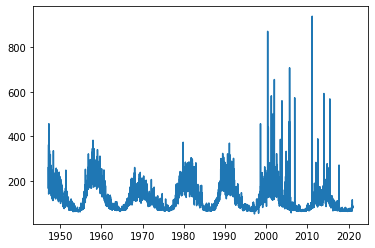

Interpolating to get daily value...
No missing data!
Linearly interpolating missing data...
Training set:    (20731, 15) (20731, 5) (20731, 5)
Validation set:  (5183, 15) (5183, 5) (5183, 5)
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @140599255755576
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @140599255754288
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @140599255755184
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @140599255753784
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @140599554983136
     | -- GenericBlock(units=128, thetas_dim=8, back

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


grad_step = 000050, tr_loss = 0.108887, vl_loss = 0.220917
grad_step = 000100, tr_loss = 0.005385, vl_loss = 0.220917


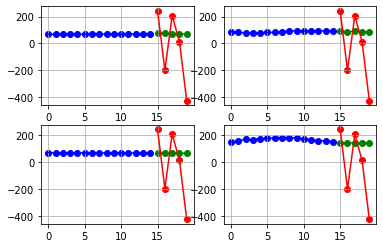

1/10 iterations
Restored checkpoint from models/nbeats-training-checkpoint.th.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


grad_step = 000150, tr_loss = 0.001420, vl_loss = 0.004107
grad_step = 000200, tr_loss = 0.000885, vl_loss = 0.004107


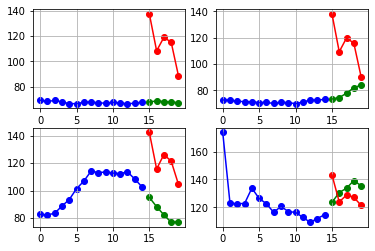

2/10 iterations
Restored checkpoint from models/nbeats-training-checkpoint.th.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


grad_step = 000250, tr_loss = 0.000632, vl_loss = 0.000324
grad_step = 000300, tr_loss = 0.000563, vl_loss = 0.000324


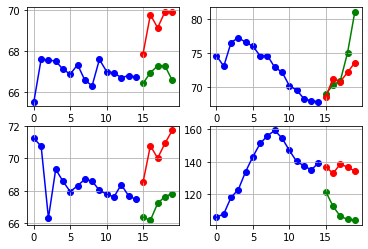

3/10 iterations
Restored checkpoint from models/nbeats-training-checkpoint.th.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


grad_step = 000350, tr_loss = 0.000531, vl_loss = 0.000206
grad_step = 000400, tr_loss = 0.000515, vl_loss = 0.000206


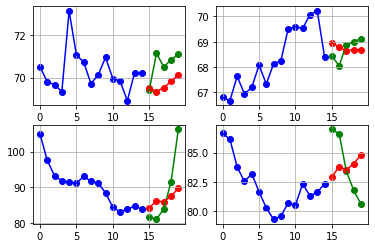

4/10 iterations
Restored checkpoint from models/nbeats-training-checkpoint.th.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


grad_step = 000450, tr_loss = 0.000495, vl_loss = 0.000208
grad_step = 000500, tr_loss = 0.000510, vl_loss = 0.000208


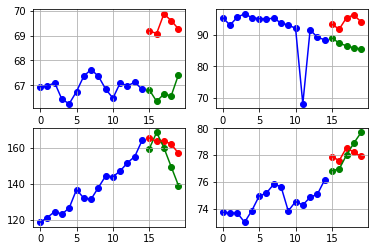

5/10 iterations
Restored checkpoint from models/nbeats-training-checkpoint.th.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


grad_step = 000550, tr_loss = 0.000468, vl_loss = 0.000218
grad_step = 000600, tr_loss = 0.000468, vl_loss = 0.000218


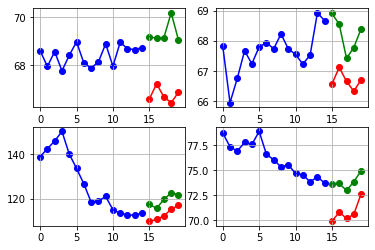

6/10 iterations
Restored checkpoint from models/nbeats-training-checkpoint.th.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


grad_step = 000650, tr_loss = 0.000483, vl_loss = 0.000192
grad_step = 000700, tr_loss = 0.000482, vl_loss = 0.000192


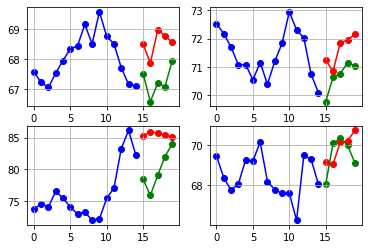

7/10 iterations
Restored checkpoint from models/nbeats-training-checkpoint.th.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


grad_step = 000750, tr_loss = 0.000472, vl_loss = 0.000194
grad_step = 000800, tr_loss = 0.000459, vl_loss = 0.000194


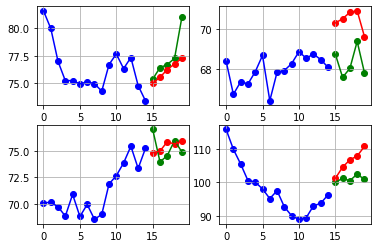

8/10 iterations
Restored checkpoint from models/nbeats-training-checkpoint.th.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


grad_step = 000850, tr_loss = 0.000481, vl_loss = 0.000230
grad_step = 000900, tr_loss = 0.000449, vl_loss = 0.000230


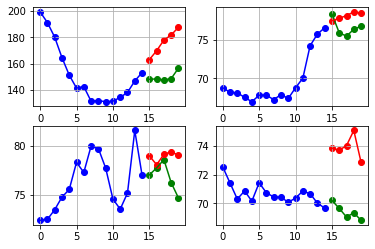

9/10 iterations
Restored checkpoint from models/nbeats-training-checkpoint.th.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


grad_step = 000950, tr_loss = 0.000467, vl_loss = 0.000179
grad_step = 001000, tr_loss = 0.000442, vl_loss = 0.000179


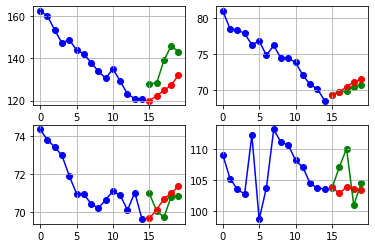

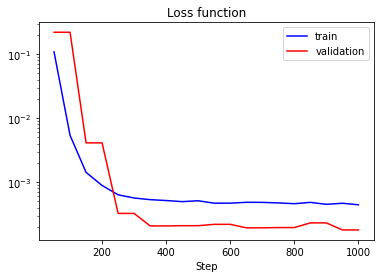

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


NBEATS          VALIDATION SET forecast MSE, MAPE, CC:  65.487455,   4.438747,   0.961435


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
../lib/read_data.py:450: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.ds >= ldate][df.ds <= udate]


ESA             forecast MSE, MAPE, CC:  30.976839,   2.700422,   0.755427
NBEATS          forecast MSE, MAPE, CC:  25.782302,   2.826011,   0.799348
CLS             forecast MSE, MAPE, CC:  33.881730,   4.541937,   0.741224
PERSISTENCE     forecast MSE, MAPE, CC:  40.556745,   2.873167,   0.700960


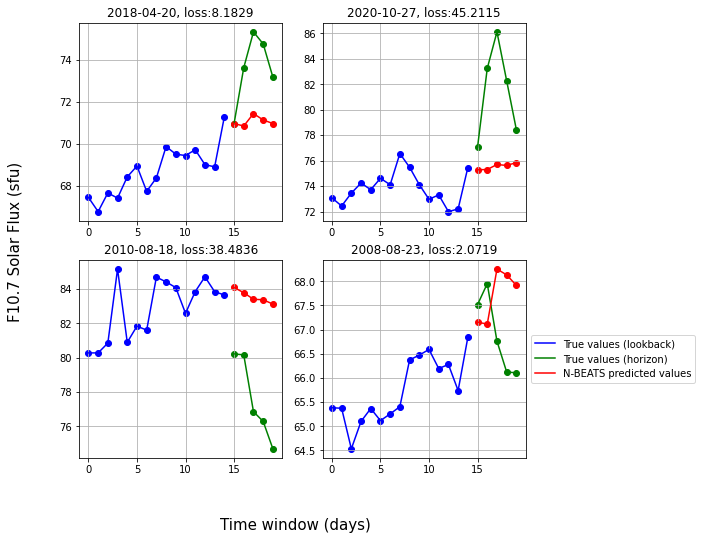

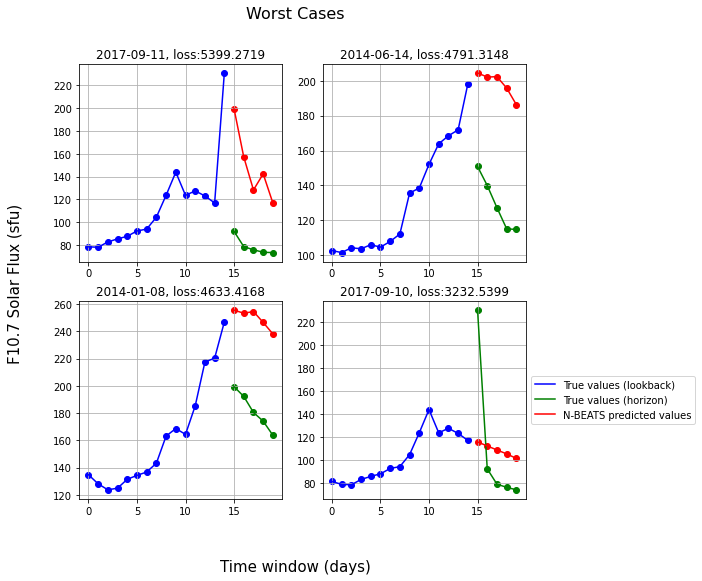

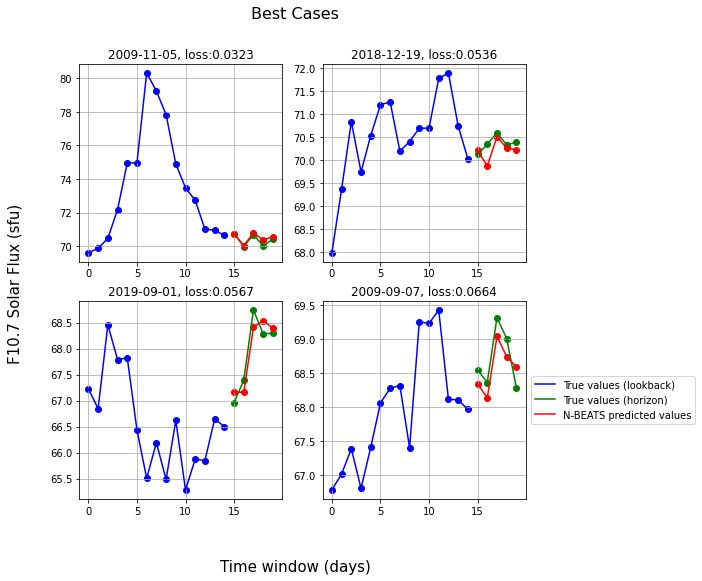

Run Successful


In [133]:
# export
if __name__ == '__main__':
    main()

In [149]:
run.finish()

Training Losses,0.00044
Validation Losses,0.00018
_step,21
_runtime,92
_timestamp,1612955972
NBEATS_VALID MSE,65.48746
NBEATS_VALID MAPE,4.43875
NBEATS_VALID CC,0.96144
ESA MSE,30.97684
ESA MAPE,2.70042
ESA CC,0.75543


Training Losses,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Losses,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅█
NBEATS_VALID MSE,▁
NBEATS_VALID MAPE,▁
NBEATS_VALID CC,▁
ESA MSE,▁
ESA MAPE,▁
ESA CC,▁


## EXPORT

In [1]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_stats_utils.ipynb.
Converted 02_plot_utils.ipynb.
Converted 03_read_data.ipynb.
Converted 04_model.ipynb.
Converted 05_solar_flux_time_series_forecasting.ipynb.
Converted 06_ensemble_utils.ipynb.
Converted index.ipynb.


## Inference on a Test Set

In [134]:
# manually assign to second GPU if first is full (nvidia-smi, nvtop)
torch.cuda.set_device(1)
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

In [135]:
config = AttrDict()
config.update(user_config)
config

{'data_src': 'esa',
 'data_comp': ['esa', 'cls'],
 'date_llim': '1949-12-31',
 'date_ulim': '2021-01-01',
 'get_daily_method': 'interp',
 'missing_data_method': 'interp_linear',
 'esa_archive_fname': '../data/archive/F10.7DailyObservedFluxDensity.txt',
 'esa_forecast_fname': '../data/forecast/F10.7_IndexForecast27day_BGS_2017.txt',
 'esa_archive_key': 'f10_7',
 'esa_forecast_key': 'F107_NMH_esforc',
 'cls_datadir': '../data/cls',
 'cls_key': 'f10.7',
 'cls_forecast_ldate': '2016-12-31',
 'cls_forecast_udate': '2021-01-01',
 'cls_adj': False,
 'horizon': 5,
 'lookback': 15,
 'lookback_hfactor': '3H',
 'step': 1,
 'incl_test': False,
 'test_pct': 0.1,
 'valid_pct': 0.2,
 'batch_size': 'max',
 'hidden_layer_units': 128,
 'nb_blocks_per_stack': 3,
 'thetas_dims': [7, 8],
 'share_weights_in_stack': False,
 'stack_type1': 'generic',
 'stack_type2': 'generic',
 'assign_seed': False,
 'seed': 103115806466,
 'optimiser': 'RAdam',
 'learning_rate': 0.001,
 'momentum': 0.5,
 'loss_func': 'mse',
 

Training data source: ESA


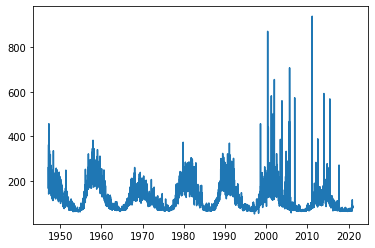

Interpolating to get daily value...
No missing data!
Linearly interpolating missing data...
Training set:    (18657, 15) (18657, 5) (18657, 5)
Validation set:  (4665, 15) (4665, 5) (4665, 5)
Test set:        (2592, 15) (2592, 5) (2592, 5)


In [136]:
# 1. dataloader with test set
config["incl_test"] = True
data = cSWEDataLoader(config, verbose=True, plot=True)
data.fget_data()
data.device = device

In [137]:
data.test.x

array([[0.24144617, 0.24242766, 0.24786743, ..., 0.25437188, 0.2419286 ,
        0.23369408],
       [0.24242766, 0.24786743, 0.25611859, ..., 0.2419286 , 0.23369408,
        0.23801928],
       [0.24786743, 0.25611859, 0.27791096, ..., 0.23369408, 0.23801928,
        0.22203266],
       ...,
       [0.136377  , 0.13609419, 0.13677624, ..., 0.13730858, 0.1482713 ,
        0.14600889],
       [0.13609419, 0.13677624, 0.13496299, ..., 0.1482713 , 0.14600889,
        0.14705692],
       [0.13677624, 0.13496299, 0.1351127 , ..., 0.14600889, 0.14705692,
        0.14728982]])

In [138]:
data.test.y

array([[0.23801928, 0.22203266, 0.21018826, 0.19588181, 0.19185605],
       [0.22203266, 0.21018826, 0.19588181, 0.19185605, 0.21647644],
       [0.21018826, 0.19588181, 0.19185605, 0.21647644, 0.21626018],
       ...,
       [0.14705692, 0.14728982, 0.14630833, 0.14517712, 0.14416236],
       [0.14728982, 0.14630833, 0.14517712, 0.14416236, 0.14055248],
       [0.14630833, 0.14517712, 0.14416236, 0.14055248, 0.13819025]])

In [139]:
data.test.t # t = dates over forecast window (data.test.y)

array([['2013-11-23', '2013-11-24', '2013-11-25', '2013-11-26',
        '2013-11-27'],
       ['2013-11-24', '2013-11-25', '2013-11-26', '2013-11-27',
        '2013-11-28'],
       ['2013-11-25', '2013-11-26', '2013-11-27', '2013-11-28',
        '2013-11-29'],
       ...,
       ['2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
        '2020-12-29'],
       ['2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
        '2020-12-30'],
       ['2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30',
        '2020-12-31']], dtype='<U10')

In [140]:
config["horizon"], config["lookback"], len(data.test.t[0])

(5, 15, 5)

In [141]:
# 2. read in best model

# get untrained NBeats
model = fget_model(config, device) 

# update with trained weights
model_fname = config.model_fname #"models/best.pth"

# solar-plant-55
#api = wandb.Api()
#run = api.run("stardust-r/deep-learning-space-weather-forecasting/1ahnqshm")
#run.config["model_fname"]

model_dict  = torch.load(model_fname)
model.load_state_dict(model_dict['model_state_dict'])

print('Restored checkpoint from {}.'.format(model_fname))

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @140599554982576
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @140595438646216
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @140595440536600
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @140595440534360
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @140595440533856
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @140595440534528
Restored checkpoint from models/best.pth.


In [142]:
# 3. Interpretation class & fget_preds
interp = cInterp(model, data, config, device, dset="test", verbose=True, plot=True)
interp.fget_preds() # this returns times, targs, preds

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [143]:
interp.preds_denorm # denormalised predictions

array([[137.04309 , 133.61386 , 133.12141 , 132.60858 , 132.39066 ],
       [142.46213 , 140.01735 , 140.86288 , 140.8749  , 139.71524 ],
       [133.77446 , 131.97197 , 131.52876 , 132.44907 , 132.32619 ],
       ...,
       [ 89.69885 ,  91.025   ,  91.371445,  91.4393  ,  91.97739 ],
       [ 89.52522 ,  90.598724,  90.22185 ,  90.014915,  90.858345],
       [ 89.33916 ,  90.01824 ,  88.6796  ,  88.54689 ,  88.77915 ]],
      dtype=float32)

In [144]:
interp.targs_denorm # denormalised data.test.y

array([[143.08, 133.47, 126.35, 117.75, 115.33],
       [133.47, 126.35, 117.75, 115.33, 130.13],
       [126.35, 117.75, 115.33, 130.13, 130.  ],
       ...,
       [ 88.4 ,  88.54,  87.95,  87.27,  86.66],
       [ 88.54,  87.95,  87.27,  86.66,  84.49],
       [ 87.95,  87.27,  86.66,  84.49,  83.07]])

In [145]:
interp.inp_denorm # denormalised data.test.x

array([[145.14, 145.73, 149.  , ..., 152.91, 145.43, 140.48],
       [145.73, 149.  , 153.96, ..., 145.43, 140.48, 143.08],
       [149.  , 153.96, 167.06, ..., 140.48, 143.08, 133.47],
       ...,
       [ 81.98,  81.81,  82.22, ...,  82.54,  89.13,  87.77],
       [ 81.81,  82.22,  81.13, ...,  89.13,  87.77,  88.4 ],
       [ 82.22,  81.13,  81.22, ...,  87.77,  88.4 ,  88.54]])

In [146]:
interp.window_times # data.test.t

array([['2013-11-23', '2013-11-24', '2013-11-25', '2013-11-26',
        '2013-11-27'],
       ['2013-11-24', '2013-11-25', '2013-11-26', '2013-11-27',
        '2013-11-28'],
       ['2013-11-25', '2013-11-26', '2013-11-27', '2013-11-28',
        '2013-11-29'],
       ...,
       ['2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
        '2020-12-29'],
       ['2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
        '2020-12-30'],
       ['2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30',
        '2020-12-31']], dtype='<U10')

In [147]:
interp.pred_date # "gendate", first date of horizon

array(['2013-11-23', '2013-11-24', '2013-11-25', ..., '2020-12-25',
       '2020-12-26', '2020-12-27'], dtype='<U10')

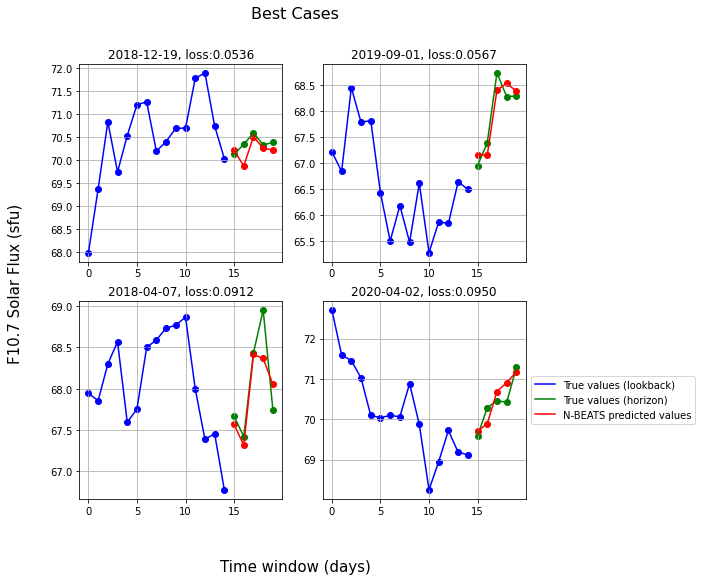

In [148]:
# 4. plot
pltobj = cPlotForecast(interp, config.lookback, config.horizon)
#pltobj.fplot_forecast()
#pltobj.fplot_top_losses(largest=True)
pltobj.fplot_top_losses(largest=False)